In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pymc3 as pm

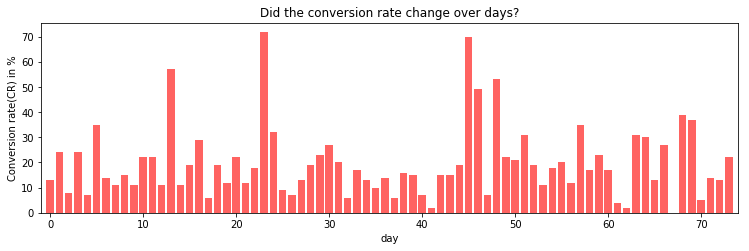

In [25]:
plt.figure(figsize=(12.5, 3.5))
count_data = np.loadtxt("data/cvdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#ff6361")
plt.xlabel("day")
plt.ylabel("Conversion rate(CR) in %")
plt.title("Did the conversion rate change over days?")
plt.xlim(-1, n_count_data)
plt.savefig("figures/BDE/1.png", dpi = 200)
plt.show()

In [26]:

import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)

In [27]:
with model:
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

In [28]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)

In [29]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 4 chains: 100%|██████████| 60000/60000 [00:21<00:00, 2802.13draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [30]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

In [31]:
lambda_1_samples

array([19.00141075, 19.00141075, 19.00141075, ..., 18.13761823,
       18.13761823, 18.13761823])

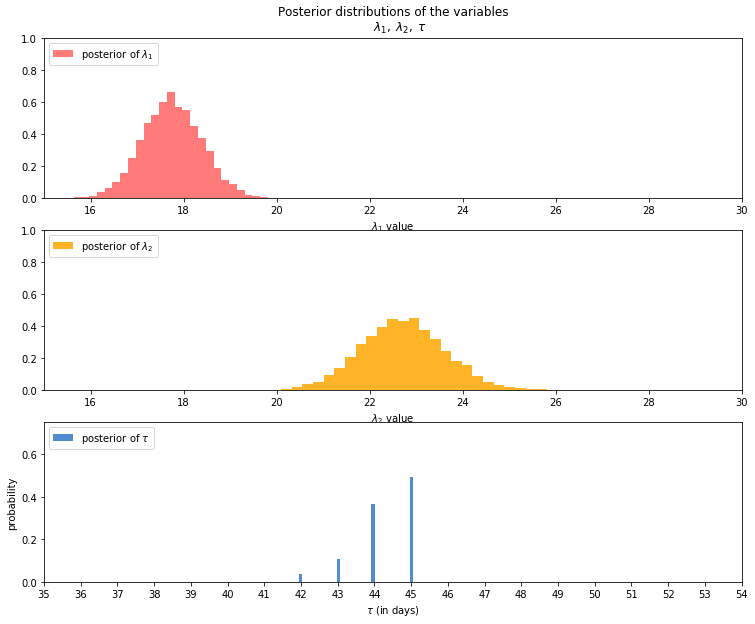

In [32]:
plt.figure(figsize=(12.5, 10))
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#ff6361", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#ffa600", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#518CD0", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability")
plt.savefig("figures/BDE/2.png", dpi = 200)
plt.show()


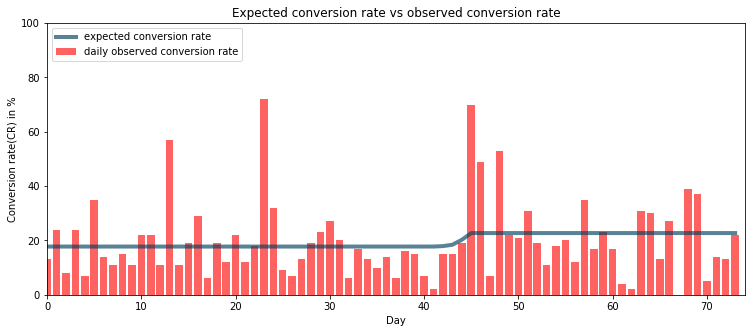

In [33]:

plt.figure(figsize=(12.5, 5))
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#003f5c", alpha= 0.65,
         label="expected conversion rate")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Conversion rate(CR) in %")
plt.title("Expected conversion rate vs observed conversion rate")
plt.ylim(0, 100)
plt.bar(np.arange(len(count_data)), count_data, color="#ff6361", alpha=1,
        label="daily observed conversion rate")

plt.legend(loc="upper left")
plt.savefig("figures/BDE/3.png", dpi = 200)